In [1]:
%load_ext autoreload

In [2]:
%autoreload

import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import color.data.dataset as color_dataset
import color.utils.utils as utils

In [6]:
# Get colors dataset
dataset = color_dataset.Dataset(dataset='small', emb_len=50, normalize_rgb=True, var_seq_len=True, add_stop_word=True)

Loading colors dataset
Loading embeddings
Splitting dataset


In [7]:
class LSTMColorNamer(nn.Module):
    
    def __init__(self, **kwargs):
        super(LSTMColorNamer, self).__init__()
        self.params = {
            'emb_dim': 50,
            'hidden_dim': 50,
            'num_layers': 1,
            'dropout': 0,
            'color_dim': 3,  # But don't change
        }
        self.params.update(kwargs)
        
        self.rgb2emb = nn.Linear(self.params['color_dim'], self.params['emb_dim'])
        self.lstm = nn.LSTM(self.params['emb_dim'], self.params['hidden_dim'],
                            num_layers=self.params['num_layers'], dropout=self.params['dropout'])
        self.hidden2emb = nn.Linear(self.params['hidden_dim'], self.params['emb_dim'])
        
        
    def forward(self, rgb, emb):
        rgb2emb_out = self.rgb2emb(rgb)
        rgb2emb_out = rgb2emb_out.reshape(1, *rgb2emb_out.shape)
       
        emb = torch.cat((rgb2emb_out, emb[:-1]), dim=0)     
        lstm_out = self.lstm(emb)
        
        return self.hidden2emb(lstm_out[0])
        
    def gen_name(self, rgb):
        rgb2emb_out = self.rgb2emb(rgb)
        rgb2emb_out = rgb2emb_out.reshape(1, *rgb2emb_out.shape)
        lstm_out, lstm_state = self.lstm(rgb2emb_out)
        
        while True:
            emb = yield self.hidden2emb(lstm_out[0])
            lstm_out, lstm_state = self.lstm(emb, lstm_state)

In [8]:
m = LSTMColorNamer()
print(utils.get_trainable_params(m))
rgb = torch.Tensor(32, 3)
emb = torch.Tensor(4, 32, 50)
m(rgb, emb).shape

23150


torch.Size([4, 32, 50])

In [9]:
# Train
num_epochs = 30
model = LSTMColorNamer()
optimizer = torch.optim.SGD(model.parameters(), lr=0.07)
loss_fn = nn.MSELoss()
losses = []

for epoch in range(num_epochs):
    tot_loss = 0
    for i, (rgb, embedding, _) in enumerate(dataset.train_loader):
        model.zero_grad()
        embedding_preds = model(rgb, embedding)
        loss = loss_fn(embedding, embedding_preds)
        loss.backward()
        tot_loss += loss.detach().numpy()
        optimizer.step()
    print('Epoch Complete : {}'.format(epoch+1))
    losses.append(tot_loss)

Epoch Complete : 1
Epoch Complete : 2
Epoch Complete : 3
Epoch Complete : 4
Epoch Complete : 5
Epoch Complete : 6
Epoch Complete : 7
Epoch Complete : 8
Epoch Complete : 9
Epoch Complete : 10
Epoch Complete : 11
Epoch Complete : 12
Epoch Complete : 13
Epoch Complete : 14
Epoch Complete : 15
Epoch Complete : 16
Epoch Complete : 17
Epoch Complete : 18
Epoch Complete : 19
Epoch Complete : 20
Epoch Complete : 21
Epoch Complete : 22
Epoch Complete : 23
Epoch Complete : 24
Epoch Complete : 25
Epoch Complete : 26
Epoch Complete : 27
Epoch Complete : 28
Epoch Complete : 29
Epoch Complete : 30


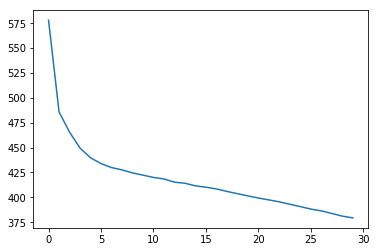

In [10]:
# Plot loss per epoch (should be going down)
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses)

In [26]:
# # Runs a new color name throught the model to predict its color
# def predict(model, dataset, color_names):
#     color_name_embs = [
#         torch.tensor(color_dataset.to_embeddings(name, dataset.vocab_dict, dataset.embeddings)).float()
#         for name in color_names
#     ]
#     with torch.no_grad():
#         preds = []
#         for emb in color_name_embs:
#             pred_rgb = model(emb.view(1, emb.shape[0], -1))
#             preds.append(torch.Tensor.tolist(pred_rgb.view(-1)))
#         return preds
# color_preds = predict(model, dataset, ['red'])
# print(color_preds)
# p = patches.Rectangle((0,0), 5, 5, color=color_preds[0])
# fig,ax = plt.subplots(1)
# ax.add_patch(p)

In [11]:
def predict_name(model, dataset, rgb, max_len=3, stop_word=False):
    rgb = torch.FloatTensor(rgb).view(1, 3)
    rgb = rgb / 256
    
    embs = torch.FloatTensor(dataset.embeddings)
    embs_mag = torch.sqrt(torch.sum(embs*embs, dim=1)).reshape(-1)
    
    name = []
    sims = []
    
    with torch.no_grad():
        name_generator = model.gen_name(rgb)
        next_emb = None
        for i in range(max_len):
            emb_pred = name_generator.send(next_emb).view(-1,1)
            emb_pred_mag = torch.sqrt(torch.sum(emb_pred*emb_pred))
            emb_dot = torch.mm(embs, emb_pred).view(-1)
            embs_sim = emb_dot / (embs_mag * emb_pred_mag)
        
            nearest_idx = int(torch.argmax(embs_sim))
            word, sim = dataset.vocab[nearest_idx], float(embs_sim[nearest_idx])
            if stop_word and word == 'STOP_WORD':
                print('Stop Word', i+1)
                break
            name.append(word)
            sims.append(sim)
            next_emb = dataset.embeddings[nearest_idx]
            next_emb = torch.FloatTensor(next_emb).view(1,1,-1)
        
    return name, sims
        
        

In [21]:
predict_name(model, dataset, (222, 10, 200), stop_word=True) # red

Stop Word 3


(['pink', 'fruit'], [0.8256202936172485, 0.7854865193367004])